In [ ]:
import numpy as np
import sklearn

import matplotlib.pyplot as plt
%matplotlib inline

## Goals:
---
- **Implement kernel logistic regression**
- **Implement kernel SVM**

***
Utilities
----
***

In [2]:
import cvxopt

def cvxopt_qp(P, q, G, h, A, b):
    P = .5 * (P + P.T)
    cvx_matrices = [
        cvxopt.matrix(M) if M is not None else None for M in [P, q, G, h, A, b] 
    ]
    #cvxopt.solvers.options['show_progress'] = False
    solution = cvxopt.solvers.qp(*cvx_matrices, options={'show_progress': False})
    return np.array(solution['x']).flatten()

solve_qp = cvxopt_qp

### Data generation

In [3]:
# Simulate data
np.random.seed(54321)
p = 2

def generate_Xy(n_samples, p=404, sigma=1):
    # Half of y is 1s, other half is -1
    y = np.ones(n_samples)
    mid = int(n_samples / 2)
    y[mid:] *= -1
    
    X = np.random.normal(0, sigma, (n_samples, p))
    X[y == 1] /= 10
    X += (1 - y[:, np.newaxis]) / 2 # add 1 when y = -1
    # X of shape (n, p)
    # y vector of length n
    return X, y



### Plotting

In [4]:
# Visualize training data
def plot_data(X, y):
    plt.figure(figsize=(8,7))
    plt.scatter(X[:, 0], X[:, 1], c=y)
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
    plt.show()
    
plot_data(X_test, y_test)

NameError: name 'X_test' is not defined

In [5]:
plot_data(X_train, y_train)

NameError: name 'X_train' is not defined

In [6]:
# Visualize training data and separating hyperplane
def compute_margins(b, w1, w2, x1):
    '''
    returns x2 such that:
        - f(x) = 0
        - f(x) = 1
        - f(x) = -1
    '''
    x2 = (-b - w1 * x1) / w2
    x2_up = (-b - w1 * x1 - 1) / w2
    x2_low = (-b - w1 * x1 + 1) / w2
    
    return x2, x2_up, x2_low

def plot_points_with_margin(X, y, w, b):
    plt.figure(figsize=(8,7))

    # Training data
    plt.scatter(X[:,0], X[:,1], c=y)
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')

    # Separating hyperplane and decision boundaries
    x1 = np.linspace(X[:,0].min(), X[:,0].max(), 100)
    w1, w2 = w
    x2, x2_up, x2_low = compute_margins(b, w1, w2, x1)

    plt.plot(x1, x2, 'b')
    plt.plot(x1, x2_up, 'b--')
    plt.plot(x1, x2_low, 'b--')

    # Plot
    plt.show()

[LibLinear]w [-0.74938544 -1.08306453]
b [1.10852416]


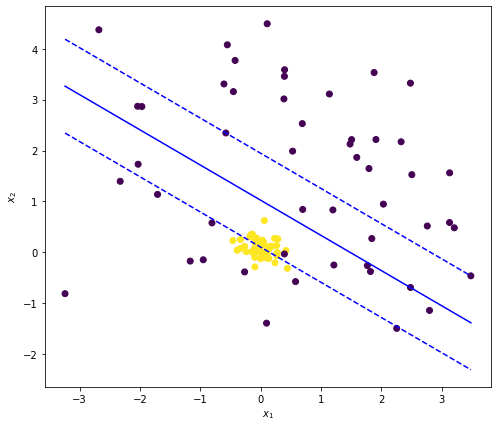

In [7]:
from sklearn.svm import LinearSVC

clf = LinearSVC(penalty='l2', loss='hinge', C=1., verbose=1)
# Train the model
clf.fit(X_train, y_train)
print('w', clf.coef_[0])
print('b', clf.intercept_)
plot_points_with_margin(X_train, y_train, clf.coef_[0], clf.intercept_[0])

In [8]:
# Prediction error
def error(ypred, ytrue):
    e = (ypred != ytrue).mean()
    return e

def add_column_ones(X):
    n = X.shape[0]
    return np.hstack([X, np.ones((n, 1))])

# Visualization
# References: https://scikit-learn.org/stable/auto_examples/svm/plot_iris.html
def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(classifier, xx, yy, add_intercept=False, **params):
    """Plot the decision boundaries for a classifier.
    
    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    X = np.c_[xx.ravel(), yy.ravel()]
    if add_intercept:
        X = add_column_ones(X)
    Z = classifier.predict(X)
    Z = Z.reshape(xx.shape)
    out = plt.contourf(xx, yy, Z, **params)
    return out

def plot_decision_function(classifier, X_train, y_train, title='', add_intercept=False):
    fig = plt.figure(figsize=(8,7))
    X0, X1 = X_train[:, 0], X_train[:, 1]
    xx, yy = make_meshgrid(X0, X1)
    plot_contours(classifier, xx, yy, cmap=plt.cm.GnBu, alpha=0.5, add_intercept=add_intercept)
    plt.scatter(X0, X1, c=y_train, cmap=plt.cm.GnBu, s=20, edgecolors='k')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
    plt.title(title)
    plt.show()

***
Example kernel implementations
----
***

In [6]:
def rbf_kernel(X1, X2, sigma=10):
    '''
    Returns the kernel matrix K(X1_i, X2_j): size (n1, n2)
    where K is the RBF kernel with parameter sigma
    
    Input:
    ------
    X1: an (n1, p) matrix
    X2: an (n2, p) matrix
    sigma: float
    '''
    # For loop with rbf_kernel_element works but is slow in python
    # Use matrix operations!
    X2_norm = np.sum(X2 ** 2, axis = -1)
    X1_norm = np.sum(X1 ** 2, axis = -1)
    gamma = 1 / (2 * sigma ** 2)
    K = np.exp(- gamma * (X1_norm[:, None] + X2_norm[None, :] - 2 * np.dot(X1, X2.T)))
    return K

def sigma_from_median(X):
    '''
    Returns the median of ||Xi-Xj||
    
    Input
    -----
    X: (n, p) matrix
    '''
    pairwise_diff = X[:, :, None] - X[:, :, None].T
    pairwise_diff *= pairwise_diff
    euclidean_dist = np.sqrt(pairwise_diff.sum(axis=1))
    return np.median(euclidean_dist)

In [7]:
def linear_kernel(X1, X2):
    '''
    Returns the kernel matrix K(X1_i, X2_j): size (n1, n2)
    where K is the linear kernel
    
    Input:
    ------
    X1: an (n1, p) matrix
    X2: an (n2, p) matrix
    '''
    return X1.dot(X2.T)

def quadratic_kernel(X1, X2):
    '''
    Returns the kernel matrix K(X1_i, X2_j): size (n1, n2)
    where K is the quadratic kernel
    
    Input:
    ------
    X1: an (n1, p) matrix
    X2: an (n2, p) matrix
    '''
    return (1 + linear_kernel(X1, X2))**2  

***
# Kernel Methods
***

*Kernel trick in a nutshell:*
1. In the optimization problem and in the decision function, **express all dependencies on the data $X$ by scalar products $X_1 X_2^\top$**
2. **Replace these scalar products $X_1 X_2^\top$ by kernel matrices $K_{X_1, X_2}$**

Whhat we are doing:
- Training a model on data $\phi(x)$

In [9]:
class KernelMethodBase(object):
    '''
    Base class for kernel methods models
    
    Methods
    ----
    fit
    predict
    '''
    kernels_ = {
        'linear': linear_kernel,
        'quadratic': quadratic_kernel,
        'rbf': rbf_kernel,
        #if you want to add your own kernel
        #'customer_kernel':custom_kernel
    }
    def __init__(self, kernel='linear', **kwargs):
        self.kernel_name = kernel
        self.kernel_function_ = self.kernels_[kernel]
        self.kernel_parameters = self.get_kernel_parameters(**kwargs)
        
    def get_kernel_parameters(self, **kwargs):
        params = {}
        if self.kernel_name == 'rbf':
            params['sigma'] = kwargs.get('sigma', None)
            
#         if self.kernel_name == 'customer_kernel':
#             params['parameter_1'] = kwargs.get('parameter_1', None)
#             params['parameter_2'] = kwargs.get('parameter_2', None)
        return params

    def fit(self, X, y, **kwargs):
        return self
        
    def decision_function(self, X):
        pass
    
    def predict(self, X):
        pass
    
    

    def Accuracy_check(self, X):
        pass

***
## Kernel Logistic Regression
***

We are going to implement the kernel version of the IRLS algorithm

### Kernel Ridge Regression
First a reminder on Kernel Ridge Regression:

The prediction rule is:
$$\hat{y}(X_t) = \color{darkorange}{X_t X^\top}(\color{darkorange}{XX^\top} + \lambda n I)^{-1} y$$

#### Adding weights:
To transform into Weighted Kernel Ridge Regression, with non-negative weights $w$ set:
- $W = \mathrm{Diag}(\sqrt{w})$
- $\tilde{X} = WX$, $\tilde{y} = Wy$

In [10]:
class KernelRidgeRegression(KernelMethodBase):
    '''
    Kernel Ridge Regression
    '''
    def __init__(self, lambd=0.1, **kwargs):
        self.lambd = lambd
        # Python 3: replace the following line by
        # super().__init__(**kwargs)
        super(KernelRidgeRegression, self).__init__(**kwargs)

    def fit(self, X, y, sample_weights=None):
        n, p = X.shape
        assert (n == len(y))
    
        self.X_train = X
        self.y_train = y
        
        if sample_weights is not None:
            w_sqrt = np.sqrt(sample_weights)
            self.X_train = self.X_train * w_sqrt[:, None]
            self.y_train = self.y_train * w_sqrt
        # Hint the kernel matrix is computed by
        #K=self.kernet_function_(X, X, **self.kernel_parameters)
        
        A = self.kernel_function_(X, X, **self.kernel_parameters)
        A[np.diag_indices_from(A)] += n*self.lambd
        # self.alpha = (K + n lambda I)^-1 y
        self.alpha = np.linalg.solve(A , self.y_train)

        return self
    
    def decision_function(self, X):
        K_x = self.kernel_function_ (X, self.X_train, **self.kernel_parameters)
        return K_x.dot(self.alpha)
    
    def predict(self, X):
        return self.decision_function(X)

Test

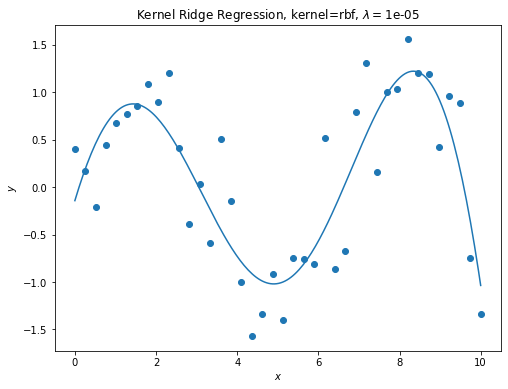

In [13]:
xtrain = np.linspace(0, 10, 40)
ytrain = np.sin(xtrain) + 0.5 * np.random.randn(len(xtrain))
xtest = np.linspace(0, 10, 200)

kernel = 'rbf'
lambd = 1e-05 #0.0001 #1
sigma = 5#0.05  #5
model = KernelRidgeRegression(
        kernel=kernel,
        lambd=lambd,
        sigma=sigma
    ).fit(xtrain[:, None], ytrain)
ypred = model.predict(xtest[:, None])

plt.figure(figsize=(8, 6))
plt.scatter(xtrain, ytrain)
plt.plot(xtest, ypred)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('Kernel Ridge Regression, kernel={}, $\lambda=${}'.format(kernel, lambd))
plt.show()

In [14]:
ytrain.shape

(40,)

In [15]:
xtest.shape

(200,)

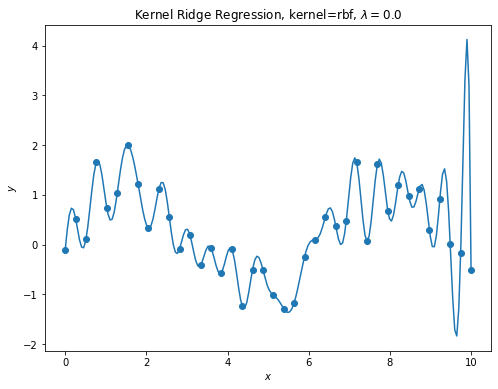

In [16]:
xtrain = np.linspace(0, 10, 40)
ytrain = np.sin(xtrain) + 0.5 * np.random.randn(len(xtrain))
xtest = np.linspace(0, 10, 200)

kernel = 'rbf'
lambd = 0.0 #1
sigma = .5  #5
model = KernelRidgeRegression(
        kernel=kernel,
        lambd=lambd,
        sigma=sigma
    ).fit(xtrain[:, None], ytrain)
ypred = model.predict(xtest[:, None])

plt.figure(figsize=(8, 6))
plt.scatter(xtrain, ytrain)
plt.plot(xtest, ypred)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('Kernel Ridge Regression, kernel={}, $\lambda=${}'.format(kernel, lambd))
plt.show()

To perform binary classification:
train with y=-1 and 1

prediction = np.sign(model.predict(X))

***
### Kernel Logistic Regression
***
(see slides from the $MVA$ course for more details)

- **Optimization problem**

 The kernel version of the logistic regression problem is stated as follows:
$$
\min_\alpha J(\alpha) =  \frac{1}{n} \sum_{i=1}^n {\log \, \sigma(y_i (K \mathbf{\alpha})_i) } + \lambda \mathbf{\alpha}^\top K \mathbf{\alpha} \,.
$$

- **Decision function**:

 The decision function is then $$\color{green}{\hat{f}(X_{test}) = \sigma(K_{X_{test}, X_{train}} \alpha)}$$
 
***
#### IRLS
Update step:$$\alpha^{new} \leftarrow \min_\alpha J_q(\alpha)$$
Where the quadratic approximation $J_q$ is defined by:
$$
J(\alpha) \approx J_q(\alpha) := J(\alpha^{old}) + (\alpha - \alpha^{old})^\top \alpha J(\alpha^{old}) + \frac{1}{2} (\alpha - \alpha^{old})^\top \nabla^2 J(\alpha^{old}) (\alpha - \alpha^{old})
$$

One can show that:
$$2 J_q(\alpha) = (K\alpha−z)^\top W(K\alpha−z)+\lambda\alpha^\top K \alpha+C$$

For the following values of $W$ and $z$:
- $m_i = [K \alpha^{old}]_i$
- $W_i = \sigma(m_i) \sigma(-m_i)$
- $z_i = m_i + y_i / {\sigma(y_i m_i)}$

This is the kernel ridge

In [17]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


class KernelLogisticRegression(KernelMethodBase):
    '''
    Kernel Logistic Regression
    '''
    def __init__(self, lambd=0.1, **kwargs):
        self.lambd = lambd
        # Python 3: replace the following line by
        # super().__init__(**kwargs)
        super(KernelLogisticRegression, self).__init__(**kwargs)

    def fit(self, X, y, max_iter=100, tol=1e-5):
        n, p = X.shape
        assert (n == len(y))
    
        self.X_train = X
        self.y_train = y
        
        K = self.kernel_function_(X, X, **self.kernel_parameters)
        
        # IRLS
        KRR = KernelRidgeRegression(
            lambd=2*self.lambd,
            kernel=self.kernel_name,
            **self.kernel_parameters
        )
        # Initialize
        alpha = np.zeros(n)
        # Iterate until convergence or max iterations
        for n_iter in range(max_iter):
            alpha_old = alpha
            m = K.dot(alpha_old)
            w = sigmoid(m)*sigmoid(-m)
            z = m + y/ sigmoid(y*m)
            alpha = KRR.fit(self.X_train, z, sample_weights= w).alpha
            
            # Break condition (achieved convergence)
            if np.sum((alpha-alpha_old)**2) < tol:
                break

        self.n_iter = n_iter
        self.alpha = alpha

        return self
            
    def decision_function(self, X_test):
        K_x = self.kernel_function_(X_test, self.X_train, **self.kernel_parameters)
        # probability of y=1(between o and 1)
        return sigmoid(K_x.dot(self.alpha))

    def predict(self, X):
        probas =self.decision_function(X)
        predicted_classes = np.where(probas < 0.5, -1,1)
        return predicted_classes

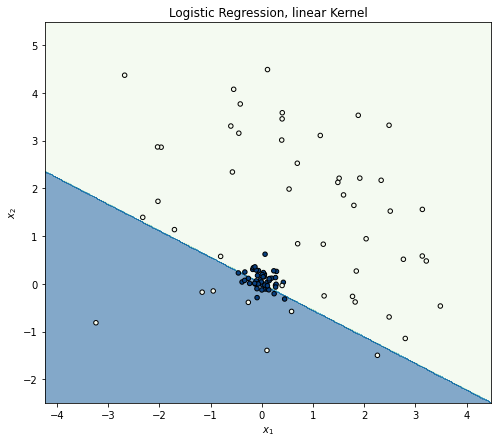

Test error: 35.40%


In [18]:
kernel = 'linear'
sigma = .4
lambd = 1.
fig_title = 'Logistic Regression, {} Kernel'.format(kernel)

model = KernelLogisticRegression(lambd=lambd, kernel=kernel, sigma=sigma)
y_pred = model.fit(X_train, y_train).predict(X_test)
plot_decision_function(model, X_train, y_train, title=fig_title)
print('Test error: {:.2%}'.format(error(y_pred, y_test)))

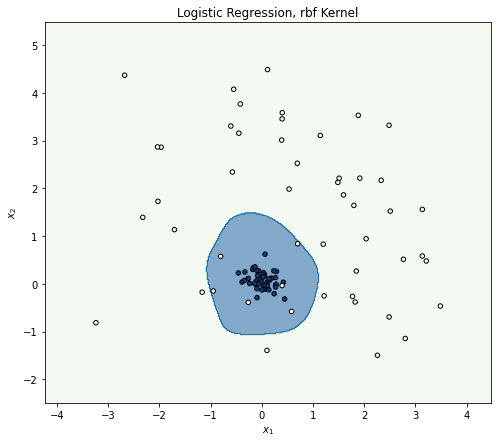

Test error: 8.10%


In [19]:
kernel = 'rbf'
sigma = .4
lambd = 1.
fig_title = 'Logistic Regression, {} Kernel'.format(kernel)

model = KernelLogisticRegression(lambd=lambd, kernel=kernel, sigma=sigma)
y_pred = model.fit(X_train, y_train).predict(X_test)
plot_decision_function(model, X_train, y_train, title=fig_title)
print('Test error: {:.2%}'.format(error(y_pred, y_test)))

#### Adding an intercept in our logistic regression

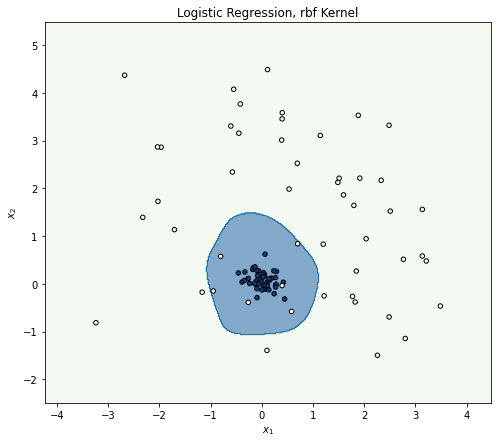

Test error: 8.10%


In [20]:
X_train_with_intercept = add_column_ones(X_train)
X_test_with_intercept = add_column_ones(X_test)

y_pred = model.fit(X_train_with_intercept, y_train).predict(X_test_with_intercept)
plot_decision_function(model, X_train, y_train, add_intercept=True,
                       title='Logistic Regression, {} Kernel'.format(kernel))
print('Test error: {:.2%}'.format(error(y_pred, y_test)))

#### Comparison with `sklearn`

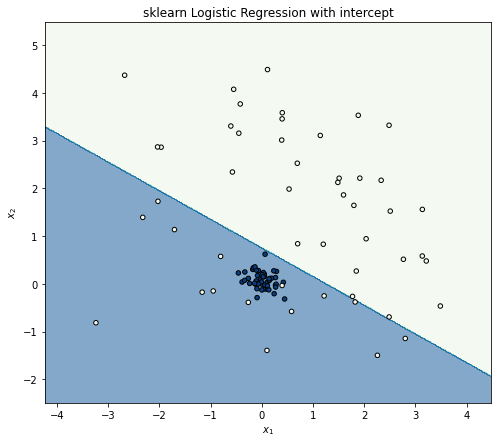

Test error: 18.40%


In [21]:
intercept = True
clf = sklearn.linear_model.LogisticRegression(C=1/lambd, fit_intercept=intercept).fit(X_train, y_train)
y_pred = clf.fit(X_train, y_train).predict(X_test)
title = 'sklearn Logistic Regression'
if intercept:
    title += ' with intercept'
plot_decision_function(clf, X_train, y_train, title=title)
print('Test error: {:.2%}'.format(error(y_pred, y_test)))

***
## Kernel SVM
***

- **Soft-margin dual problem:**
$$
\begin{aligned}
\max_\alpha & \, \mathrm{1}^\top\alpha -\frac{1}{2}\alpha^\top y_{diag} \color{darkorange}{X X^\top} y_{diag} \alpha \\
\mathrm{s.t. } \, & \alpha \geq 0 \\
& \alpha \leq C \\
& y^\top\alpha = 0
\\
\end{aligned}
$$

 *Kernel trick:* Replace $\color{darkorange}{X X^\top}$ with $\color{darkorange}{K_{X,X}}$
 
- **Decision function**
$$f(X_{test}) = X_{test} w + b$$
 - $w = \sum_{i=1}^n \alpha_i y_i x_i$
 - $b = y_{i^*} - w^\top x_{i^*}$ for support vectors $i^*$
 
 *Kernel trick:* Rewrite $f(X_{test})$ using only the kernel $K$
 $$f(X_{test})= \color{darkorange}{X_{test} X_{train}^T}\beta +b$$

where 
- $\beta := a . y$ is the elementwise product of $\alpha$ and $y$ $(\beta_i = \alpha_i *y_i)$
- $b$ is the average of $\color{darkorange}{X_{test} X_{train}^T}\beta$
- sv = support vectors=  subset of training set

In [11]:
def svm_dual_soft_to_qp_kernel(K, y, C=1):
    n = K.shape[0]
    assert (len(y) == n)
        
    # Dual formulation, soft margin
    P = np.diag(y).dot(K).dot(np.diag(y))
    # As a regularization, we add epsilon * identity to P
    eps = 1e-12
    P += eps * np.eye(n)
    q = - np.ones(n)
    G = np.vstack([-np.eye(n), np.eye(n)])
    h = np.hstack([np.zeros(n), C * np.ones(n)])
    A = y[np.newaxis, :]
    A = A.astype('float')
    b = np.array([0.])
    return P, q, G, h, A, b

K = linear_kernel(X_train, X_train)
alphas = solve_qp(*svm_dual_soft_to_qp_kernel(K, y_train, C=1.))

NameError: name 'X_train' is not defined

In [34]:
class KernelSVM(KernelMethodBase):
    '''
    Kernel SVM Classification
    
    Methods
    ----
    fit
    predict
    '''
    def __init__(self, C=0.1, **kwargs):
        self.C = C
        # Python 3: replace the following line by
        # super().__init__(**kwargs)
        super(KernelSVM, self).__init__(**kwargs)

    def fit(self, X, y, tol=1e-1):
        n, p = X.shape
        assert (n == len(y))
    
        self.X_train = X
        self.y_train = y
        
        # Kernel matrix
        K = self.kernel_function_(X, X, **self.kernel_parameters)
        
        # Solve dual problem
        self.alpha = solve_qp(*svm_dual_soft_to_qp_kernel(K, y, C=self.C))
        
        # Compute support vectors and bias b
        sv = np.logical_and((self.alpha>tol), (self.C - self.alpha > tol))
        self.bias = y[sv] - K[sv].dot(self.alpha*y)
        self.bias =  self.bias.mean()

        self.support_vector_indices = np.nonzero(sv)[0]

        return self
        
    def predict(self, X, threshold):
#         y_pred = self.kernel(X, self.X_).dot(self.alphas* seld.y_)
        K_x = self.kernel_function_(X, self.X_train, **self.kernel_parameters)
        return np.where((K_x.dot(self.alpha * self.y_train) +  self.bias) >= threshold, 1, 0)
        
          
    def Accuracy_check(self,X, y, threshold=.5):
        return np.mean(self.predict(X, threshold)==y)

time: 20.7 ms


In [18]:
# @title Imports

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import cvxopt
np.random.seed(54321)

import ipdb

import optuna

from sklearn.model_selection import KFold 
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.preprocessing import OneHotEncoder

from kernels.basic import RBF, Linear, Polynomial
from kernels.regular import rbf_kernel, Exponential, Laplacian, RationalQuadratic, \
                            InverseMultiquadratic, Cauchy, TStudent, ANOVA, Fourier, Tanimoto, Sorensen

%load_ext autotime

In [19]:
X_train_ = pd.read_csv('./data/Xtr.csv', sep=',') #we use this dataset to train our model
Y_train_ = pd.read_csv('./data/Ytr.csv', sep=',') #we use this dataset to train our model
X_test_ = pd.read_csv('./data/Xte.csv', sep=',')

time: 13 ms


In [20]:
X_train_ = pd.read_csv('./data/Xtr.csv', sep=',') #we use this dataset to train our model
Y_train_ = pd.read_csv('./data/Ytr.csv', sep=',') #we use this dataset to train our model
X_test_ = pd.read_csv('./data/Xte.csv', sep=',')

kfold=KFold(n_splits=5)

def spectrum_kernal(X_train, y, X_test, n=2, encoder=8, one_hot = True, normalise = False):
    
    d = {'A': 1, 'C':2, 'G':3, 'T':4}
    
    for i in range(0, 101-n+1, 1):
        X_train['seq_'+str(i)] = X_train.seq.apply(lambda x :x[i:i+n])
        X_test['seq_'+str(i)] = X_test.seq.apply(lambda x :x[i:i+n])
        
        X_train['seq_'+str(i)] = X_train['seq_'+str(i)].apply(lambda x : sum([d[x[ii]]*encoder**(ii+1) for ii in range(n)]))
        X_test['seq_'+str(i)] = X_test['seq_'+str(i)].apply(lambda x : sum([d[x[ii]]*encoder**(ii+1) for ii in range(n)]))
        
        
        
    X = X_train.drop(['seq', 'Id'], axis=1)
    X_t = X_test.drop(['seq', 'Id'], axis=1)
    y = y.Bound
    
#     print(f'Train: \n{X.tail()}\n -----------------------\n')
#     print(f'Test: \n {X_t.tail()}')

    if one_hot:
        onehot_encoder = OneHotEncoder(sparse=False, categories='auto', handle_unknown='ignore')

        X_cross = X.values
        X_t = X_t.values
        
        enc = onehot_encoder.fit(X)
        X_cross = enc.transform(X)
        X_t_enc = enc.transform(X_t)
        
    elif normalise:
        scaler = MinMaxScaler()#MinMaxScaler() # StandardScaler()
        scaler.fit(X)
        
        X_cross = scaler.transform(X)
        X_t_enc = scaler.transform(X_t)
        
    else :
        
        X_cross = X.values
        X_t_enc = X_t.values
    
    y_cross = y.values
    
    return X_cross, y_cross, X_t_enc

time: 62.3 ms


In [21]:
X_cross, y_cross, X_t_enc = spectrum_kernal(X_train_, Y_train_, X_test_, n=1, encoder=8, one_hot = False, normalise = False)

time: 843 ms


In [35]:
# from kernels.basic import RBF, Linear, Polynomial
# from kernels.regular import Exponential, Laplacian, RationalQuadratic, \
#                             InverseMultiquadratic, Cauchy, TStudent, ANOVA, Fourier, Tanimoto, Sorensen

def objective_sgd(trial):
    
#     q  = trial.suggest_loguniform('q', 1e-5, 4e+0)
    
    sigma  = trial.suggest_loguniform('sigma', 1e-2, 8e+0) # trial.suggest_float('sigma', 1e-5, 1e-3, log=True)

    c = trial.suggest_loguniform('c', 1, 8)
    
    n = trial.suggest_int('n', 1, 3)

    X_cross, y_cross, X_t_enc = spectrum_kernal(X_train_, Y_train_, X_test_, n=n, encoder=8, one_hot = True, normalise = False)
    
#     for model in models:
    accuracy = []
    for i, (train_index, validate_index) in enumerate(kfold.split(X_cross)):
        X_train, y_train = X_cross[train_index], y_cross[train_index]
        X_valid, y_valid = X_cross[validate_index], y_cross[validate_index]

#             ipdb.set_trace()
        
        model = KernelSVM(C=c, kernel='rbf', sigma=sigma)
        model_curr = model.fit(X_train, y_train)

        accuracy.append(model.Accuracy_check(X_valid, y_valid, threshold=0.5))
                
    #       print(f'accurracy fold {i}: {accuracy[i]}')

    #         print(f'\nAverage accuracy {models[model]} is : {np.mean(accuracy)}\n')

    return np.mean(accuracy)

sampler = optuna.samplers.TPESampler()

study = optuna.create_study(sampler=sampler, direction='maximize')
study.optimize(func=objective_sgd, n_trials=200, show_progress_bar=True)


trial = study.best_trial

print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

/usr/local/lib/python3.6/dist-packages/optuna/_experimental.py:90: ExperimentalWarning:

Progress bar is experimental (supported from v1.2.0). The interface can change in the future.



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: RuntimeWarning:

invalid value encountered in greater_equal



[I 2020-05-31 22:41:09,777] Finished trial#0 with value: 0.501 with parameters: {'sigma': 0.18371255246461754, 'c': 6.57590681761269, 'n': 3}. Best is trial#0 with value: 0.501.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: RuntimeWarning:

invalid value encountered in greater_equal



[I 2020-05-31 22:41:29,755] Finished trial#1 with value: 0.501 with parameters: {'sigma': 0.04296239358597482, 'c': 1.627066429543921, 'n': 1}. Best is trial#0 with value: 0.501.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: RuntimeWarning:

invalid value encountered in greater_equal



[I 2020-05-31 22:41:54,027] Finished trial#2 with value: 0.501 with parameters: {'sigma': 1.8701352260839665, 'c': 6.353122782341381, 'n': 3}. Best is trial#0 with value: 0.501.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: RuntimeWarning:

invalid value encountered in greater_equal



[I 2020-05-31 22:42:18,107] Finished trial#3 with value: 0.501 with parameters: {'sigma': 0.6248298587516428, 'c': 7.445350098705487, 'n': 3}. Best is trial#0 with value: 0.501.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: RuntimeWarning:

invalid value encountered in greater_equal



[I 2020-05-31 22:42:38,568] Finished trial#4 with value: 0.501 with parameters: {'sigma': 0.08620667378429049, 'c': 1.3079051502432102, 'n': 1}. Best is trial#0 with value: 0.501.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: RuntimeWarning:

invalid value encountered in greater_equal



[I 2020-05-31 22:43:02,630] Finished trial#5 with value: 0.501 with parameters: {'sigma': 0.40692198691530274, 'c': 7.529176462074295, 'n': 3}. Best is trial#0 with value: 0.501.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: RuntimeWarning:

invalid value encountered in greater_equal



[I 2020-05-31 22:43:23,311] Finished trial#6 with value: 0.501 with parameters: {'sigma': 0.022910768213448608, 'c': 1.7416954737004604, 'n': 2}. Best is trial#0 with value: 0.501.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: RuntimeWarning:

invalid value encountered in greater_equal



[I 2020-05-31 22:43:49,160] Finished trial#7 with value: 0.501 with parameters: {'sigma': 0.9215868647384554, 'c': 2.6244467391505575, 'n': 2}. Best is trial#0 with value: 0.501.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: RuntimeWarning:

invalid value encountered in greater_equal



[I 2020-05-31 22:44:13,740] Finished trial#8 with value: 0.501 with parameters: {'sigma': 1.4529801093641497, 'c': 1.462844041400363, 'n': 1}. Best is trial#0 with value: 0.501.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: RuntimeWarning:

invalid value encountered in greater_equal



[I 2020-05-31 22:44:34,878] Finished trial#9 with value: 0.501 with parameters: {'sigma': 0.032787724365364396, 'c': 1.0244987462193234, 'n': 1}. Best is trial#0 with value: 0.501.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: RuntimeWarning:

invalid value encountered in greater_equal



[I 2020-05-31 22:44:58,787] Finished trial#10 with value: 0.501 with parameters: {'sigma': 0.17024692464774607, 'c': 4.517197667335628, 'n': 3}. Best is trial#0 with value: 0.501.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: RuntimeWarning:

invalid value encountered in greater_equal



[I 2020-05-31 22:45:17,463] Finished trial#11 with value: 0.501 with parameters: {'sigma': 0.08302992273715548, 'c': 2.5070584094392165, 'n': 2}. Best is trial#0 with value: 0.501.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: RuntimeWarning:

invalid value encountered in greater_equal



[I 2020-05-31 22:45:37,953] Finished trial#12 with value: 0.501 with parameters: {'sigma': 5.40672787440097, 'c': 3.944834690729059, 'n': 1}. Best is trial#0 with value: 0.501.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: RuntimeWarning:

invalid value encountered in greater_equal



[I 2020-05-31 22:45:58,897] Finished trial#13 with value: 0.501 with parameters: {'sigma': 0.015296466125725718, 'c': 2.0954367553932447, 'n': 2}. Best is trial#0 with value: 0.501.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: RuntimeWarning:

invalid value encountered in greater_equal



[I 2020-05-31 22:46:19,748] Finished trial#14 with value: 0.501 with parameters: {'sigma': 0.0629712516191906, 'c': 3.3387276170008238, 'n': 2}. Best is trial#0 with value: 0.501.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: RuntimeWarning:

invalid value encountered in greater_equal



[I 2020-05-31 22:46:40,231] Finished trial#15 with value: 0.501 with parameters: {'sigma': 0.1691018042162305, 'c': 5.298243995960775, 'n': 1}. Best is trial#0 with value: 0.501.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: RuntimeWarning:

invalid value encountered in greater_equal



[I 2020-05-31 22:47:04,246] Finished trial#16 with value: 0.501 with parameters: {'sigma': 0.01021345937190459, 'c': 1.077173446733455, 'n': 3}. Best is trial#0 with value: 0.501.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: RuntimeWarning:

invalid value encountered in greater_equal



[I 2020-05-31 22:47:25,447] Finished trial#17 with value: 0.501 with parameters: {'sigma': 0.22172067660195321, 'c': 3.467108739051997, 'n': 2}. Best is trial#0 with value: 0.501.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: RuntimeWarning:

invalid value encountered in greater_equal



[I 2020-05-31 22:47:45,444] Finished trial#18 with value: 0.501 with parameters: {'sigma': 0.13793721943207496, 'c': 5.390274206477292, 'n': 1}. Best is trial#0 with value: 0.501.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: RuntimeWarning:

invalid value encountered in greater_equal



[I 2020-05-31 22:48:09,741] Finished trial#19 with value: 0.501 with parameters: {'sigma': 4.4924263440276375, 'c': 1.028266296733019, 'n': 3}. Best is trial#0 with value: 0.501.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: RuntimeWarning:

invalid value encountered in greater_equal



[I 2020-05-31 22:48:35,173] Finished trial#20 with value: 0.501 with parameters: {'sigma': 0.30536131578070985, 'c': 3.5344903033405255, 'n': 2}. Best is trial#0 with value: 0.501.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: RuntimeWarning:

invalid value encountered in greater_equal



[I 2020-05-31 22:49:00,141] Finished trial#21 with value: 0.501 with parameters: {'sigma': 0.1410939816201894, 'c': 5.814997778918362, 'n': 2}. Best is trial#0 with value: 0.501.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: RuntimeWarning:

invalid value encountered in greater_equal



[I 2020-05-31 22:49:29,650] Finished trial#22 with value: 0.501 with parameters: {'sigma': 4.842548011451868, 'c': 4.691436671276447, 'n': 3}. Best is trial#0 with value: 0.501.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: RuntimeWarning:

invalid value encountered in greater_equal



[I 2020-05-31 22:49:55,554] Finished trial#23 with value: 0.501 with parameters: {'sigma': 2.669514762354276, 'c': 2.07379680173312, 'n': 3}. Best is trial#0 with value: 0.501.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: RuntimeWarning:

invalid value encountered in greater_equal



[I 2020-05-31 22:50:17,822] Finished trial#24 with value: 0.501 with parameters: {'sigma': 0.3701136140967903, 'c': 6.314514464687871, 'n': 2}. Best is trial#0 with value: 0.501.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: RuntimeWarning:

invalid value encountered in greater_equal



[I 2020-05-31 22:50:41,864] Finished trial#25 with value: 0.501 with parameters: {'sigma': 0.5967847894539238, 'c': 4.609386226853457, 'n': 3}. Best is trial#0 with value: 0.501.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: RuntimeWarning:

invalid value encountered in greater_equal



[I 2020-05-31 22:51:03,343] Finished trial#26 with value: 0.501 with parameters: {'sigma': 3.161139026002642, 'c': 2.352167414816282, 'n': 3}. Best is trial#0 with value: 0.501.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: RuntimeWarning:

invalid value encountered in greater_equal



[I 2020-05-31 22:51:27,391] Finished trial#27 with value: 0.501 with parameters: {'sigma': 1.886457905747613, 'c': 2.039739311591978, 'n': 3}. Best is trial#0 with value: 0.501.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: RuntimeWarning:

invalid value encountered in greater_equal



[I 2020-05-31 22:51:52,239] Finished trial#28 with value: 0.501 with parameters: {'sigma': 0.48296631143098706, 'c': 6.677414731998024, 'n': 3}. Best is trial#0 with value: 0.501.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: RuntimeWarning:

invalid value encountered in greater_equal



[I 2020-05-31 22:52:16,385] Finished trial#29 with value: 0.501 with parameters: {'sigma': 7.9270969399488616, 'c': 2.9593602649589092, 'n': 3}. Best is trial#0 with value: 0.501.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: RuntimeWarning:

invalid value encountered in greater_equal



[I 2020-05-31 22:52:38,942] Finished trial#30 with value: 0.501 with parameters: {'sigma': 0.9635888693649561, 'c': 2.143793829627072, 'n': 3}. Best is trial#0 with value: 0.501.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: RuntimeWarning:

invalid value encountered in greater_equal



[I 2020-05-31 22:53:02,911] Finished trial#31 with value: 0.501 with parameters: {'sigma': 2.4522730681477154, 'c': 1.8007156677074203, 'n': 3}. Best is trial#0 with value: 0.501.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: RuntimeWarning:

invalid value encountered in greater_equal



[I 2020-05-31 22:53:26,690] Finished trial#32 with value: 0.501 with parameters: {'sigma': 7.641124574577058, 'c': 7.920130918543524, 'n': 3}. Best is trial#0 with value: 0.501.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: RuntimeWarning:

invalid value encountered in greater_equal



[I 2020-05-31 22:53:50,878] Finished trial#33 with value: 0.501 with parameters: {'sigma': 1.1551402712122862, 'c': 2.8763296889440735, 'n': 3}. Best is trial#0 with value: 0.501.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: RuntimeWarning:

invalid value encountered in greater_equal



[I 2020-05-31 22:54:14,784] Finished trial#34 with value: 0.501 with parameters: {'sigma': 7.466548521907862, 'c': 1.6815387947603675, 'n': 3}. Best is trial#0 with value: 0.501.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: RuntimeWarning:

invalid value encountered in greater_equal



[I 2020-05-31 22:54:35,721] Finished trial#35 with value: 0.501 with parameters: {'sigma': 0.2906464773961497, 'c': 5.729784365959034, 'n': 2}. Best is trial#0 with value: 0.501.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: RuntimeWarning:

invalid value encountered in greater_equal



[I 2020-05-31 22:54:56,216] Finished trial#36 with value: 0.501 with parameters: {'sigma': 0.04820665291187705, 'c': 4.569395909853323, 'n': 2}. Best is trial#0 with value: 0.501.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: RuntimeWarning:

invalid value encountered in greater_equal



[I 2020-05-31 22:55:17,672] Finished trial#37 with value: 0.501 with parameters: {'sigma': 0.10796653485335134, 'c': 3.7330572595715474, 'n': 2}. Best is trial#0 with value: 0.501.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: RuntimeWarning:

invalid value encountered in greater_equal



[I 2020-05-31 22:55:41,924] Finished trial#38 with value: 0.501 with parameters: {'sigma': 0.22656459076808955, 'c': 6.9375475453814355, 'n': 3}. Best is trial#0 with value: 0.501.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: RuntimeWarning:

invalid value encountered in greater_equal



[I 2020-05-31 22:56:06,704] Finished trial#39 with value: 0.501 with parameters: {'sigma': 3.906068225781543, 'c': 5.737927238902023, 'n': 3}. Best is trial#0 with value: 0.501.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: RuntimeWarning:

invalid value encountered in greater_equal



[I 2020-05-31 22:56:30,720] Finished trial#40 with value: 0.501 with parameters: {'sigma': 0.7924638410563835, 'c': 7.2622855668452875, 'n': 3}. Best is trial#0 with value: 0.501.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: RuntimeWarning:

invalid value encountered in greater_equal



[I 2020-05-31 22:56:55,657] Finished trial#41 with value: 0.501 with parameters: {'sigma': 0.49168745855407425, 'c': 4.225212595036951, 'n': 3}. Best is trial#0 with value: 0.501.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: RuntimeWarning:

invalid value encountered in greater_equal



[I 2020-05-31 22:57:19,808] Finished trial#42 with value: 0.501 with parameters: {'sigma': 2.818445350654862, 'c': 2.623557310117858, 'n': 3}. Best is trial#0 with value: 0.501.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: RuntimeWarning:

invalid value encountered in greater_equal



[I 2020-05-31 22:57:41,620] Finished trial#43 with value: 0.501 with parameters: {'sigma': 1.536593565411617, 'c': 2.2969297254701093, 'n': 3}. Best is trial#0 with value: 0.501.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: RuntimeWarning:

invalid value encountered in greater_equal



[I 2020-05-31 22:58:06,366] Finished trial#44 with value: 0.501 with parameters: {'sigma': 0.5791145157333506, 'c': 1.8725160846249376, 'n': 3}. Best is trial#0 with value: 0.501.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: RuntimeWarning:

invalid value encountered in greater_equal



[I 2020-05-31 22:58:30,736] Finished trial#45 with value: 0.501 with parameters: {'sigma': 0.721248120951658, 'c': 1.558798376394831, 'n': 3}. Best is trial#0 with value: 0.501.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: RuntimeWarning:

invalid value encountered in greater_equal



[I 2020-05-31 22:58:55,267] Finished trial#46 with value: 0.501 with parameters: {'sigma': 1.8120762628124338, 'c': 1.353801487492429, 'n': 3}. Best is trial#0 with value: 0.501.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: RuntimeWarning:

invalid value encountered in greater_equal



[I 2020-05-31 22:59:19,777] Finished trial#47 with value: 0.501 with parameters: {'sigma': 0.44051307671855305, 'c': 6.300961001825224, 'n': 3}. Best is trial#0 with value: 0.501.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: RuntimeWarning:

invalid value encountered in greater_equal



[I 2020-05-31 22:59:43,987] Finished trial#48 with value: 0.501 with parameters: {'sigma': 3.286536670087257, 'c': 2.7920151592308255, 'n': 3}. Best is trial#0 with value: 0.501.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: RuntimeWarning:

invalid value encountered in greater_equal



[I 2020-05-31 23:00:05,639] Finished trial#49 with value: 0.501 with parameters: {'sigma': 6.312453236041238, 'c': 2.4244413927351087, 'n': 3}. Best is trial#0 with value: 0.501.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: RuntimeWarning:

invalid value encountered in greater_equal



[I 2020-05-31 23:00:29,889] Finished trial#50 with value: 0.501 with parameters: {'sigma': 1.064192881711649, 'c': 3.1069117721440347, 'n': 3}. Best is trial#0 with value: 0.501.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: RuntimeWarning:

invalid value encountered in greater_equal



[I 2020-05-31 23:00:54,097] Finished trial#51 with value: 0.501 with parameters: {'sigma': 1.9291862499133579, 'c': 1.9094572560678982, 'n': 3}. Best is trial#0 with value: 0.501.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: RuntimeWarning:

invalid value encountered in greater_equal



[I 2020-05-31 23:01:18,336] Finished trial#52 with value: 0.501 with parameters: {'sigma': 7.75100937497469, 'c': 1.1676145681533314, 'n': 3}. Best is trial#0 with value: 0.501.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: RuntimeWarning:

invalid value encountered in greater_equal



[I 2020-05-31 23:01:43,123] Finished trial#53 with value: 0.501 with parameters: {'sigma': 0.8814998868261176, 'c': 6.987725870017758, 'n': 3}. Best is trial#0 with value: 0.501.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: RuntimeWarning:

invalid value encountered in greater_equal



[I 2020-05-31 23:02:07,563] Finished trial#54 with value: 0.501 with parameters: {'sigma': 1.1792141526082145, 'c': 3.0426788367458393, 'n': 3}. Best is trial#0 with value: 0.501.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: RuntimeWarning:

invalid value encountered in greater_equal



[I 2020-05-31 23:02:31,756] Finished trial#55 with value: 0.501 with parameters: {'sigma': 1.3841049004547452, 'c': 1.4668273341892155, 'n': 3}. Best is trial#0 with value: 0.501.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: RuntimeWarning:

invalid value encountered in greater_equal



[I 2020-05-31 23:02:56,052] Finished trial#56 with value: 0.501 with parameters: {'sigma': 6.179846969287717, 'c': 1.6547911230749273, 'n': 3}. Best is trial#0 with value: 0.501.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: RuntimeWarning:

invalid value encountered in greater_equal



[I 2020-05-31 23:03:19,915] Finished trial#57 with value: 0.501 with parameters: {'sigma': 2.3114273171561277, 'c': 7.956949922247398, 'n': 3}. Best is trial#0 with value: 0.501.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: RuntimeWarning:

invalid value encountered in greater_equal



[I 2020-05-31 23:03:39,989] Finished trial#58 with value: 0.501 with parameters: {'sigma': 0.27174962927789087, 'c': 7.843780489416399, 'n': 1}. Best is trial#0 with value: 0.501.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: RuntimeWarning:

invalid value encountered in greater_equal



[I 2020-05-31 23:04:01,180] Finished trial#59 with value: 0.501 with parameters: {'sigma': 0.07941628402601254, 'c': 1.805059045496153, 'n': 2}. Best is trial#0 with value: 0.501.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: RuntimeWarning:

invalid value encountered in greater_equal



[I 2020-05-31 23:04:21,984] Finished trial#60 with value: 0.501 with parameters: {'sigma': 0.03502897849616049, 'c': 5.0193829941514725, 'n': 2}. Best is trial#0 with value: 0.501.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: RuntimeWarning:

invalid value encountered in greater_equal



[I 2020-05-31 23:04:43,058] Finished trial#61 with value: 0.501 with parameters: {'sigma': 0.06011249842242099, 'c': 3.979429872308217, 'n': 2}. Best is trial#0 with value: 0.501.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: RuntimeWarning:

invalid value encountered in greater_equal



[I 2020-05-31 23:05:04,156] Finished trial#62 with value: 0.501 with parameters: {'sigma': 0.10892555264868838, 'c': 5.002684828488806, 'n': 2}. Best is trial#0 with value: 0.501.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: RuntimeWarning:

invalid value encountered in greater_equal



[I 2020-05-31 23:05:25,371] Finished trial#63 with value: 0.501 with parameters: {'sigma': 0.1872325288553795, 'c': 3.874970208728285, 'n': 2}. Best is trial#0 with value: 0.501.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: RuntimeWarning:

invalid value encountered in greater_equal



[I 2020-05-31 23:05:46,258] Finished trial#64 with value: 0.501 with parameters: {'sigma': 0.022999065092960073, 'c': 5.527084574624675, 'n': 2}. Best is trial#0 with value: 0.501.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: RuntimeWarning:

invalid value encountered in greater_equal



[I 2020-05-31 23:06:11,542] Finished trial#65 with value: 0.501 with parameters: {'sigma': 0.055030394606390635, 'c': 5.917649346597258, 'n': 2}. Best is trial#0 with value: 0.501.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: RuntimeWarning:

invalid value encountered in greater_equal



[I 2020-05-31 23:06:34,600] Finished trial#66 with value: 0.501 with parameters: {'sigma': 0.22494143165357425, 'c': 7.08840193469077, 'n': 2}. Best is trial#0 with value: 0.501.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: RuntimeWarning:

invalid value encountered in greater_equal



[I 2020-05-31 23:06:55,580] Finished trial#67 with value: 0.501 with parameters: {'sigma': 0.10042220223853696, 'c': 5.768905005841239, 'n': 2}. Best is trial#0 with value: 0.501.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: RuntimeWarning:

invalid value encountered in greater_equal



[I 2020-05-31 23:07:15,640] Finished trial#68 with value: 0.501 with parameters: {'sigma': 0.36605984452470297, 'c': 4.213363117513495, 'n': 1}. Best is trial#0 with value: 0.501.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: RuntimeWarning:

invalid value encountered in greater_equal



[I 2020-05-31 23:07:39,373] Finished trial#69 with value: 0.501 with parameters: {'sigma': 0.12665584970339347, 'c': 4.433714168520637, 'n': 3}. Best is trial#0 with value: 0.501.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: RuntimeWarning:

invalid value encountered in greater_equal



[I 2020-05-31 23:08:03,464] Finished trial#70 with value: 0.501 with parameters: {'sigma': 0.21063648289702977, 'c': 3.3055357334194215, 'n': 3}. Best is trial#0 with value: 0.501.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: RuntimeWarning:

invalid value encountered in greater_equal



[I 2020-05-31 23:08:27,399] Finished trial#71 with value: 0.501 with parameters: {'sigma': 1.9969265802669742, 'c': 1.4248140676688998, 'n': 3}. Best is trial#0 with value: 0.501.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: RuntimeWarning:

invalid value encountered in greater_equal



[I 2020-05-31 23:08:51,528] Finished trial#72 with value: 0.501 with parameters: {'sigma': 3.5468464289112784, 'c': 1.1383957021675155, 'n': 3}. Best is trial#0 with value: 0.501.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: RuntimeWarning:

invalid value encountered in greater_equal



[I 2020-05-31 23:09:15,609] Finished trial#73 with value: 0.501 with parameters: {'sigma': 5.606425530506195, 'c': 1.2519147118516856, 'n': 3}. Best is trial#0 with value: 0.501.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: RuntimeWarning:

invalid value encountered in greater_equal



[I 2020-05-31 23:09:39,878] Finished trial#74 with value: 0.501 with parameters: {'sigma': 0.9112121970805299, 'c': 2.699167340094088, 'n': 3}. Best is trial#0 with value: 0.501.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: RuntimeWarning:

invalid value encountered in greater_equal



[I 2020-05-31 23:10:04,218] Finished trial#75 with value: 0.501 with parameters: {'sigma': 4.552018900273958, 'c': 6.499353214115322, 'n': 3}. Best is trial#0 with value: 0.501.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: RuntimeWarning:

invalid value encountered in greater_equal



[I 2020-05-31 23:10:32,529] Finished trial#76 with value: 0.501 with parameters: {'sigma': 1.1032442503418598, 'c': 3.042493581848883, 'n': 3}. Best is trial#0 with value: 0.501.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: RuntimeWarning:

invalid value encountered in greater_equal



[I 2020-05-31 23:11:01,486] Finished trial#77 with value: 0.501 with parameters: {'sigma': 1.3864577760885302, 'c': 3.1437575907801225, 'n': 3}. Best is trial#0 with value: 0.501.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: RuntimeWarning:

invalid value encountered in greater_equal



[I 2020-05-31 23:11:28,227] Finished trial#78 with value: 0.501 with parameters: {'sigma': 1.412275005180231, 'c': 2.430227701471615, 'n': 3}. Best is trial#0 with value: 0.501.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: RuntimeWarning:

invalid value encountered in greater_equal



KeyboardInterrupt: 

time: 30min 49s


In [48]:
#     models = {ksolveRR : 'k Ridge Reg', ksolveRR_2: 'weigh Ridge Reg', \
#               ksolveLRR: 'k Logistic Ridge Reg', KernelSVM : 'Kernal SVM'

# c  = 

sigma  = 0.1 #trial.suggest_loguniform('sigma', 1e-2, 8e+0) # trial.suggest_float('sigma', 1e-5, 1e-3, log=True)

c = 0.000001 #trial.suggest_loguniform('c', 1, 8)

n = 1# trial.suggest_int('n', 1, 3)

X_cross, y_cross, X_t_enc = spectrum_kernal(X_train_, Y_train_, X_test_, n=n, encoder=8, one_hot = True, normalise = False)

#     for model in models:
accuracy = []
for i, (train_index, validate_index) in enumerate(kfold.split(X_cross)):
    X_train, y_train = X_cross[train_index], y_cross[train_index]
    X_valid, y_valid = X_cross[validate_index], y_cross[validate_index]

#             ipdb.set_trace()

    model = KernelSVM(C=c, kernel='rbf', sigma=sigma)
    model_curr = model.fit(X_train, y_train)

    accuracy.append(model.Accuracy_check(X_valid, y_valid, threshold=0.5))

    print(f'accurracy fold {i}: {accuracy[i]}')

#         print(f'\nAverage accuracy {models[model]} is : {np.mean(accuracy)}\n')

accuracy.append(model_curr.Accuracy_check(X_valid, y_valid, threshold=0.5))
print(f'accurracy fold {i}: {accuracy[i]}')

print(f'\nAverage accuracy: {np.mean(accuracy)}\n')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: RuntimeWarning:

invalid value encountered in greater_equal



accurracy fold 0: 0.4875
accurracy fold 1: 0.4725
accurracy fold 2: 0.5475
accurracy fold 3: 0.495
accurracy fold 4: 0.5025
accurracy fold 4: 0.5025

Average accuracy: 0.50125

time: 29.8 s


In [30]:
kernel = 'rbf'
sigma = 1.
C = 1.
model = KernelSVM(C=C, kernel=kernel, sigma=sigma)
y_pred = model.fit(X_cross, y_cross).predict(X_cross, 0.5)
# plot_decision_function(model, X_cross, y_cross,
#                        title='SVM {} Kernel'.format(kernel))
print('Test error: {:.2%}'.format(model.Accuracy_check(X_cross, y_cross)))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: RuntimeWarning:

invalid value encountered in greater_equal



Test error: 50.10%
time: 8.58 s


In [60]:
# Training data
X_train, y_train = generate_Xy(2000, sigma=2)

# Testing data
X_test, y_test = generate_Xy(1000, sigma=2)

time: 97.7 ms


In [50]:
X_train.shape

(2000, 404)

time: 3.1 ms


In [51]:
y_train.shape

(2000,)

time: 2.46 ms


In [54]:
kernel = 'rbf'
sigma = 1.
C = 1.
model = KernelSVM(C=C, kernel=kernel, sigma=sigma)
y_pred = model.fit(X_train, y_train).predict(X_train)
# plot_decision_function(model, X_test, y_test,
#                        title='SVM {} Kernel'.format(kernel))
print('Test error: {:.2%}'.format(error(y_pred, y_train)))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning:

invalid value encountered in double_scalars



Test error: 100.00%
time: 9.84 s


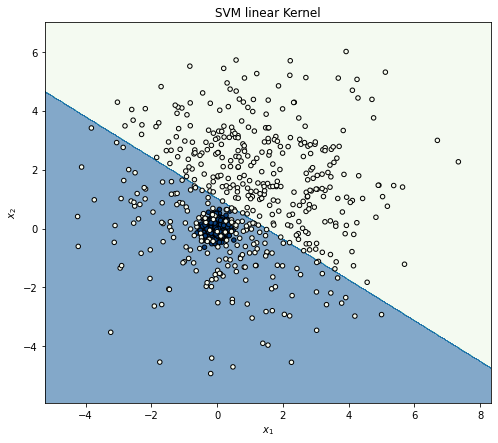

Test error: 20.30%


In [25]:
kernel = 'linear'
sigma = 1.
C = 1.
model = KernelSVM(C=C, kernel=kernel, sigma=sigma)
y_pred = model.fit(X_train, y_train).predict(X_test)
plot_decision_function(model, X_test, y_test,
                       title='SVM {} Kernel'.format(kernel))
print('Test error: {:.2%}'.format(error(y_pred, y_test)))

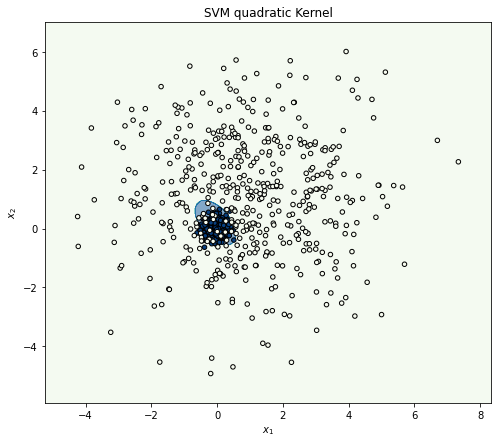

Test error: 4.50%


In [26]:
kernel = 'quadratic'
sigma = 5.
C = 100.
model = KernelSVM(C=C, kernel=kernel, sigma=sigma)
y_pred = model.fit(X_train, y_train).predict(X_test)
plot_decision_function(model, X_test, y_test,
                       title='SVM {} Kernel'.format(kernel))
print('Test error: {:.2%}'.format(error(y_pred, y_test)))

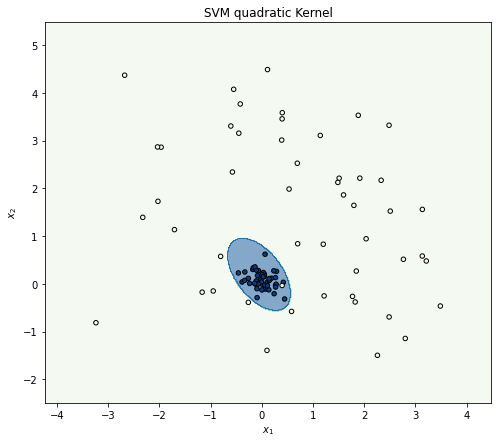

Test error: 4.50%


In [27]:
## with train data
kernel = 'quadratic'
sigma = 5.
C = 100.
model = KernelSVM(C=C, kernel=kernel, sigma=sigma)
y_pred = model.fit(X_train, y_train).predict(X_test)
plot_decision_function(model, X_train, y_train,
                       title='SVM {} Kernel'.format(kernel))
print('Test error: {:.2%}'.format(error(y_pred, y_test)))